# Tests

## Test architectures

In [8]:
import importlib

from custom_architectures import sota_eeg_arch

importlib.reload(sota_eeg_arch)

model = sota_eeg_arch.EEGSimpleConv(
    input_shape = (250, 22), output_dim = 6, multi_subjects = False
)
print(model.count_params())
print(len(model.layers))
model.summary()

1 85 15
246336
14
Model: "EEGSimpleConv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_eeg (InputLayer)      [(None, None, 22)]        0         
                                                                 
 conv1d_15 (Conv1D)          (None, None, 85)          28050     
                                                                 
 batch_normalization_21 (Ba  (None, None, 85)          340       
 tchNormalization)                                               
                                                                 
 activation_25 (Activation)  (None, None, 85)          0         
                                                                 
 conv1d_16 (Conv1D)          (None, None, 85)          108375    
                                                                 
 batch_normalization_22 (Ba  (None, None, 85)          340       
 tchNormalization)                 

In [18]:
print(model.input_shape, model.output_shape)

(None, None, 22) (None, 32)


## Step-by-step scenario execution

In [1]:
import json
import shutil
import logging
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from utils import *
from models import *
from custom_train_objects.generators import EEGGrouperGenerator
from experiments import data_utils, model_utils, scenarios_utils, scenarios

logger = logging.getLogger(__name__)

set_display_options()

for module in (model_utils, data_utils, scenarios_utils, scenarios): importlib.reload(module)

# this model is based on embeddings
name = 'eegtcnet_fit_ds-largescalebci_ge2e_metric-euclidian_nlab-5_nut-24_dim-32_ea_norm-no_winoff-0_winlen-250_passive_subj-B_scenario-1'

# This model is based on classification score for each label
#name = 'eegtcnet_fit_ds-largescalebci_ea_norm-no_winoff-0_winlen-250_passive_subj-B_scenario-1'

name = scenarios_utils.format_model_name(name, subject = range(1, 10))

config = scenarios._get_scenario_config(name, gpu = 0)
scenarios_utils.validate_scenario_config(config)

scenarios._setup_gpu_config(config)

random_state = None if not isinstance(config['run'], int) else config['run']
if random_state is not None:
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

train, valid, test, config = data_utils.get_experimental_data(
    config, random_state = random_state
)
# to remove data that are not long enough for the model as it requires fixed length input data
train = train[train['time'] == 250]
valid = valid[valid['time'] == 250]
test = test[test['time'] == 250]

#scenarios_utils.validate_scenario_data(config, train = train, valid = valid, test = test)
model, config = model_utils.build_model(name, config)

filepath =  '{}/best_weights.keras'.format(model.save_dir)
if model.epochs == 0 and not os.path.exists(filepath) and not config['skip_new']:
    config['train_config']['test_size'] = 0
    scenarios.fit_model(model, config, train = train, valid = valid, filepath = filepath)
# load the best model weights
model.load_weights(filepath)
# evaluate the model on the test subset
metrics = scenarios.evaluate_model(
    model = model, data = test, config = config, filepath = filepath, samples = train, overwrite = False
)

config['metrics'] = scenarios._get_metrics(name, config = config, metrics = metrics)

print(json.dumps(to_json(config), indent = 4))

2024-04-27 18:12:05.138437: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 18:12:05.168859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 18:12:05.168882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 18:12:05.169604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 18:12:05.174271: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_follow_type_hints is deprecated
Loading dataset largescalebci...


2024-04-27 18:12:27.718116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14948 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5



Dataset information

General :
  - sampling rate  : 200
  - # EEG channels : 22
  - Labels (n = 6) : ['Finger 1 (thumb)', 'Finger 3 (middle)', 'Finger 2 (index)', 'Finger 4 (ring)', 'passive', ...]

# Samples :
  - Train size    : 2463
  - Valid size    : 616
  - Test size     : 770
  - valid == test : False

Subjects :
  - # subject(s) in train : 1
  - # subject(s) in valid : 1
  - # subject(s) in test  : 1
  - # subject(s) in train and valid : 1
  - # subject(s) in train and test  : 1

Sessions :
  - # session(s) in train : 2
  - # session(s) in valid : 2
  - # session(s) in test  : 2
  - # session(s) in train and valid : 2
  - # session(s) in train and test  : 2

Model restoration...
Model model has not been restored due to an exception : Requested the deserialization of a Lambda layer with a Python `lambda` inside it. This carries a potential risk of arbitrary code execution and thus it is disallowed by default. If you trust the source of the saved model, you can pass `safe_mode=F

In [ ]:
# show the model information / summary of the architecture
print(model)
model.summary()

### Making prediction with the embeddings based model (i.e., with `ge2e` in its name)

An embedding model encode EEG sample on a 64-d vector, named the *embedding*. Then, it uses the *reference points* (i.e., embeddings from the training dataset) to classify the new data based on a K-Nearest Neighbor (KNN) strategy

This cell encodes each subset (train and test) for further evaluation

### Step by step evaluation

In [2]:
model.load_weights(filepath)

encoder = model if not hasattr(model, 'encoder') else model.encoder

train_samples = pd.concat([train, valid])
test_samples  = test


_labels = ('passive', 'Finger 1 (thumb)', 'Finger 3 (middle)', 'Finger 4', 'Finger 5 (pinkie)')
#_labels = None
if _labels:
    train_samples = train_samples[train_samples['label'].apply(lambda l: any(lab in l for lab in _labels))]
    test_samples = test_samples[test_samples['label'].apply(lambda l: any(lab in l for lab in _labels))]

# This creates embeddings for all the training and test data subsets
train_samples = model.build_samples(train_samples, model = encoder)
test_samples  = model.build_samples(test_samples, model = encoder)

print('Train samples : {}\ntest samples  : {}'.format(
    {k : v.shape for k, v in train_samples.items()}, {k : v.shape for k, v in test_samples.items()}
))

2024-04-27 18:18:00.012715: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


Train samples : {'ids': (2783,), 'channels': (2783, 22), 'embeddings': TensorShape([2783, 32]), 'labels': TensorShape([2783])}
test samples  : {'ids': (693,), 'channels': (693, 22), 'embeddings': TensorShape([693, 32]), 'labels': TensorShape([693])}


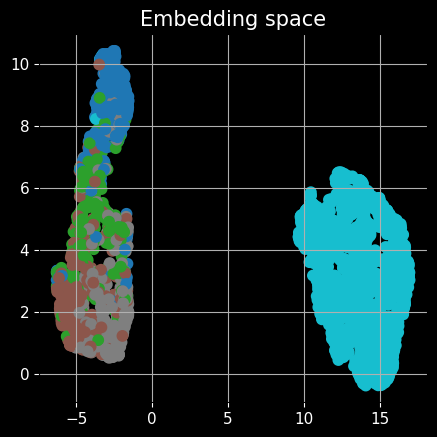

In [3]:
# visualize the training embeddings, each point represent an EEG trial, and colors represent a label
plot_embedding(train_samples['embeddings'], train_samples['labels'])

Matrix shape : (2783, 693)


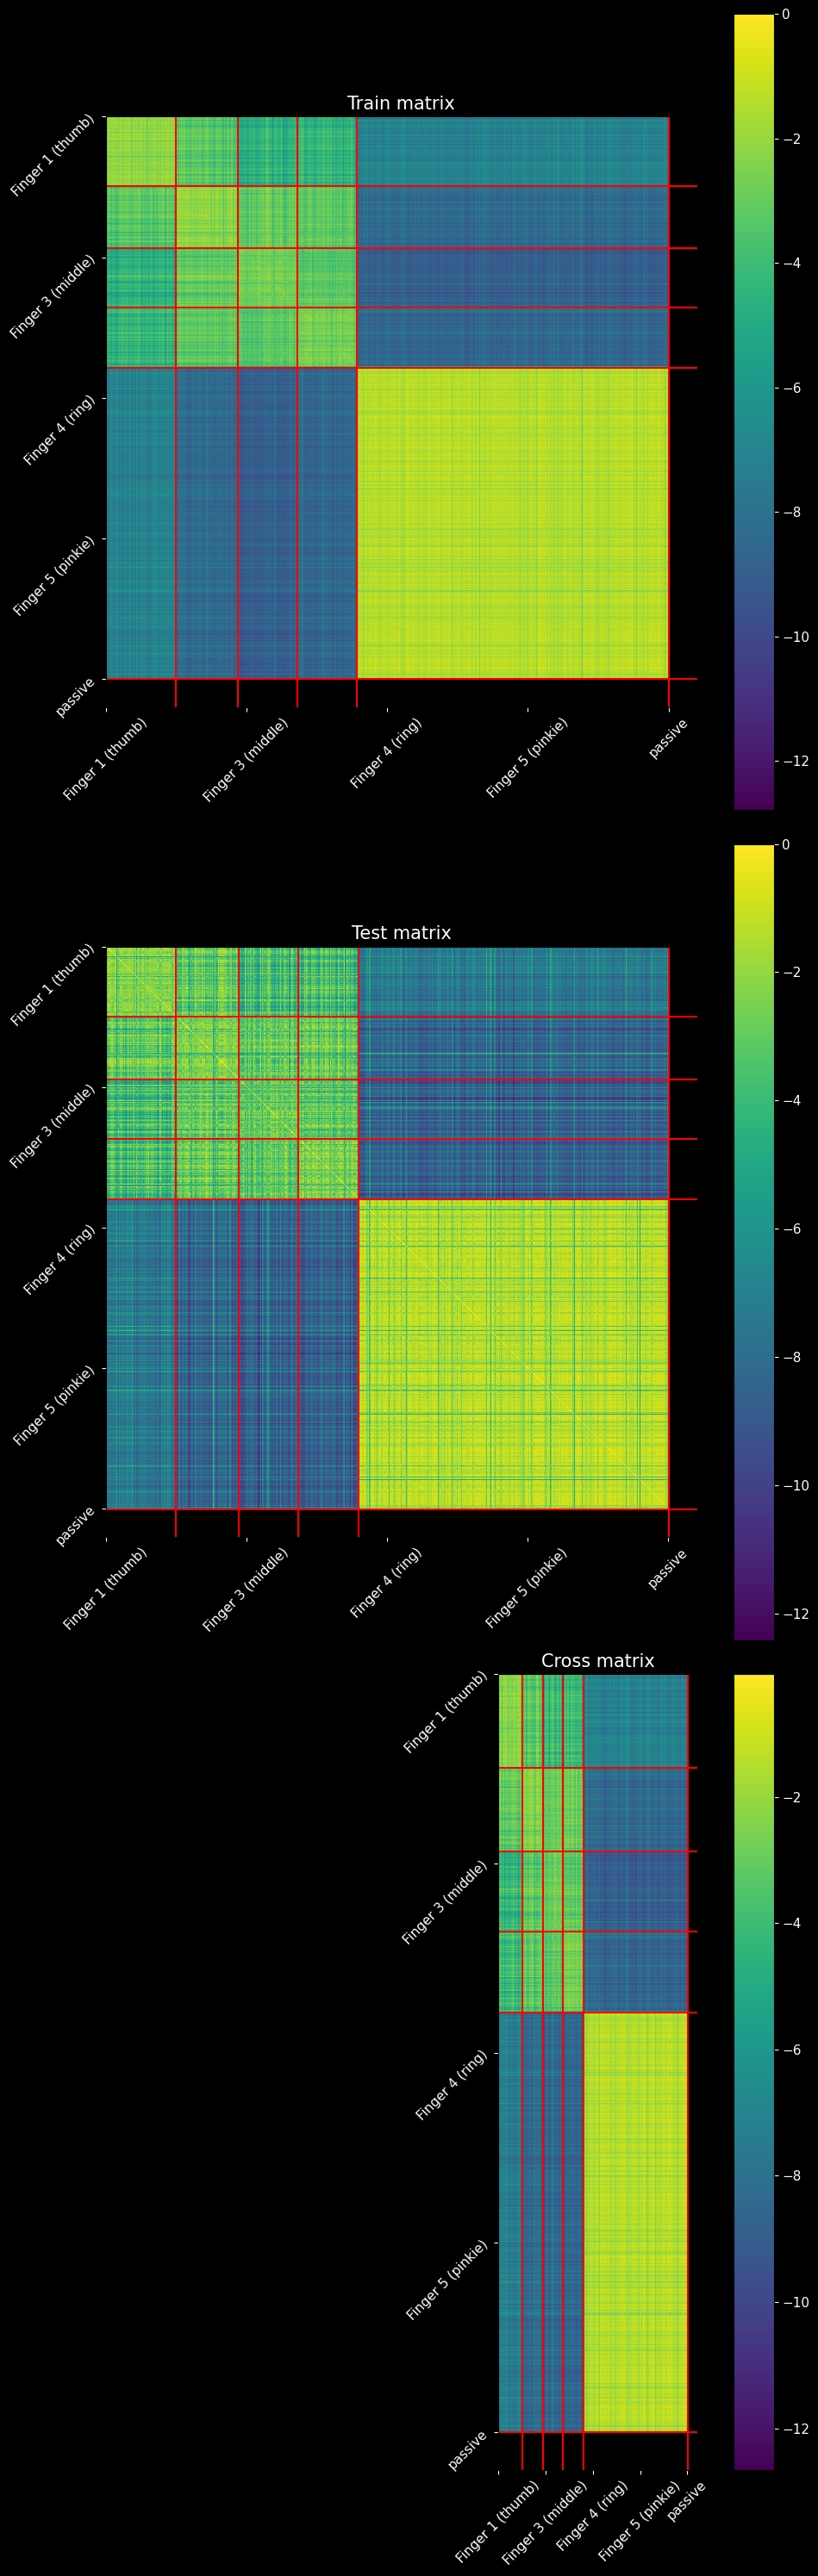

In [4]:
def reorder_samples(samples):
    embeddings, labels = samples['embeddings'], samples['labels']
    if hasattr(labels, 'numpy'): labels = labels.numpy()
    if hasattr(embeddings, 'numpy'): embeddings = embeddings.numpy()
    if len(embeddings.shape) == 3:
        embeddings, labels = np.reshape(embeddings, [-1, embeddings.shape[-1]]), np.reshape(labels, [-1])
    
    order = np.argsort(labels)
    
    labels = labels[order]
    embed  = embeddings[order]
    
    unique_ids, int_ids = tf.unique(labels)
    return embed, convert_to_str(unique_ids), int_ids, np.cumsum(np.bincount(int_ids))

train_embed, train_ids, train_idx, train_lines = reorder_samples(train_samples)
test_embed, test_ids, test_idx, test_lines = reorder_samples(test_samples)

kwargs = {'method' : getattr(model, 'distance_metric', 'euclidian'), 'force_distance' : True, 'as_matrix' : True, 'max_matrix_size' : -1}
matrix = distance(train_embed, test_embed, ** kwargs)

matrices = {
    'Train matrix' : {
        'x' : - distance(train_embed, train_embed, ** kwargs),
        'xtick_labels' : train_ids, 'ytick_labels' : train_ids, 'hlines' : train_lines, 'vlines' : train_lines
    },
    'Test matrix' : {
        'x' : - distance(test_embed, test_embed, ** kwargs),
        'xtick_labels' : test_ids, 'ytick_labels' : train_ids, 'hlines' : test_lines, 'vlines' : test_lines
    },
    'Cross matrix' : {
        'x' : - matrix,
        'xtick_labels' : test_ids, 'ytick_labels' : test_ids, 'hlines' : train_lines, 'vlines' : test_lines
    }
}

print('Matrix shape : {}'.format(matrix.shape))
plot_multiple(** matrices, ncols = 1, plot_type = 'matrix', use_subplots = True, x_size = 10, y_size = 10)

Accuracy for k = -1	: 80.09 %
Accuracy for k = 5	: 80.38 %
Accuracy for k = 10	: 79.65 %
Accuracy for k = 15	: 80.09 %
Accuracy for k = 20	: 81.39 %
Accuracy for k = 25	: 80.81 %
Accuracy for k = 30	: 80.95 %
Accuracy for k = 35	: 80.66 %
Accuracy for k = 40	: 80.52 %
Accuracy for k = 45	: 80.38 %
Accuracy for k = 50	: 80.52 %
Accuracy for k = 55	: 80.81 %
Accuracy for k = 60	: 80.81 %
Accuracy for k = 65	: 80.52 %
Accuracy for k = 70	: 80.52 %
Accuracy for k = 100	: 80.66 %
Accuracy for k = 200	: 80.95 %


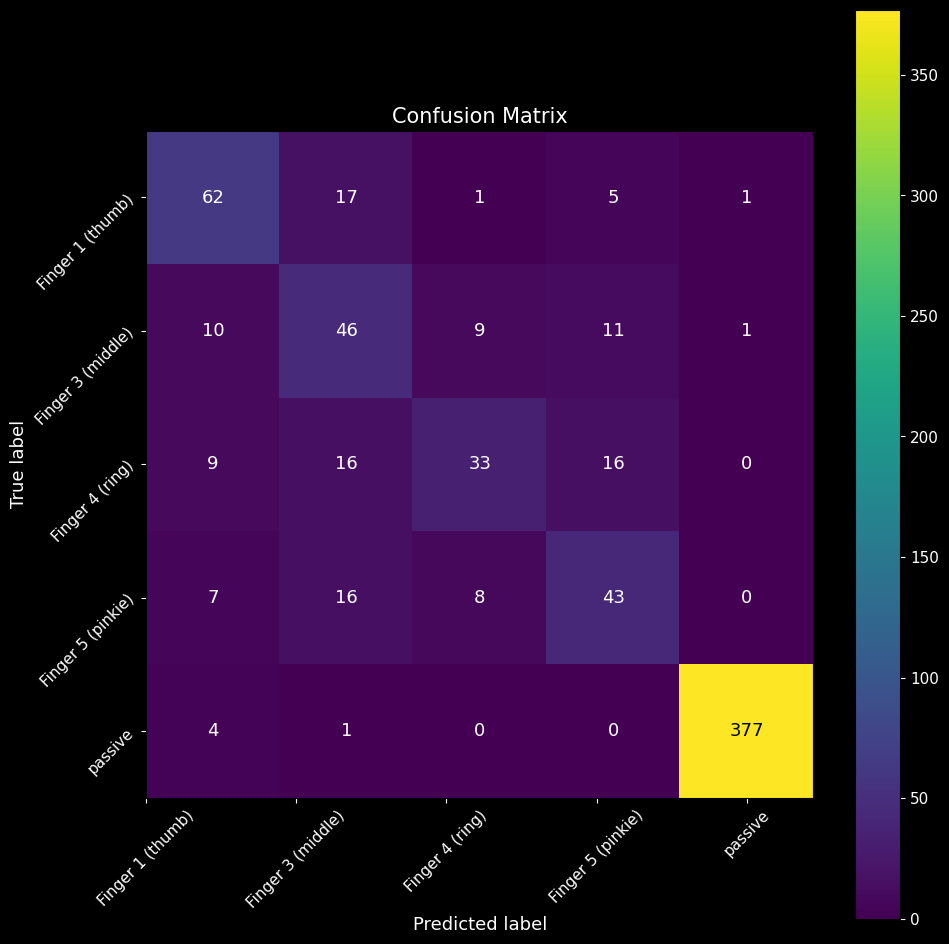

In [5]:
metric = getattr(model, 'distance_metric', 'euclidian')
#metric = 'dp'

for k in [-1] + list(range(5, 75, 5)) + [100, 200]:
    ids, embeddings = compute_centroids(train_embed, train_idx) if k == -1 else (train_idx, train_embed)
    pred = knn(
        test_embed, embeddings, distance_metric = metric, k = max(1, k), ids = ids, weighted = True
    )
    acc = pred == test_idx
    print('Accuracy for k = {}\t: {:.2f} %'.format(k, 100 * np.mean(acc)))
plot_confusion_matrix(true = test_idx, pred = pred, labels = convert_to_str(test_ids), factor_size = 2)

In [114]:
print(train_ids)

tf.Tensor([0 2 3 4 5], shape=(5,), dtype=int32)


### Step by step prediction

To predict on new data, we first have to compute the reference embeddings (with the build_samples() function), then encode the new data to classify, and finally call the KNN classifier

In [6]:
from datasets import get_dataset

def predict(x, k = 10, weighted = True):
    return knn(
        x, embeddings, distance_metric = metric, k = k, ids = ids, weighted = weighted, return_scores = True
    )

# load the complete dataset of raw data and remove the 1st relaxation phase + the index finger
real_data = get_dataset('large_scale_bci', subset = '5F', subject = 'B', keep_passive = True, keep_artifact = True)
real_data = real_data[real_data['label'] != 'Finger 2 (index)'].iloc[1:]

#concatenate all the trials in a single long EEG recording
real_eeg = np.concatenate(list(real_data['eeg'].values), axis = 1)
print(real_eeg.shape)

all_targets = []
for idx, row in real_data.iterrows():
    all_targets.extend([test_ids.index(row['label'])] * row['eeg'].shape[1])

assert len(all_targets) == real_eeg.shape[1]
real_data

Loading dataset largescalebci...
(22, 4025280)


,event_id,start,end,time,age,sex,meas_date,rate,channels,eeg,event_name,id,task,device,label,n_channels,dataset_name,session
1,99,31612,31819,207,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-2.08e-06, -4.69e-06, -3.26e-06, -1.79e-06, ...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
2,0,31819,32621,802,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-3.905e-05, -3.896e-05, -4.179e-05, -4.127e-...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
3,99,32621,32826,205,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-1.151e-05, -2.03e-05, -1.986e-05, -2.337e-0...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
4,0,32826,33429,603,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-3.189e-05, -2.617e-05, -2.836e-05, -3.388e-...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
5,99,33429,33635,206,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[4.53e-06, -1e-07, -1.71e-06, 4.64e-06, 1.58e...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11525,0,716994,717418,424,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-6.84e-06, -1.786e-05, -1.437e-05, -6.11e-06...",passive,Large scale BCI-F,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-F-160209
11526,5,717418,717677,259,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[1.105e-05, 6.1e-06, 1.1e-07, 2.92e-06, 1.431...",Finger 5 (pinkie),Large scale BCI-F,5f,EEG 1200,Finger 5 (pinkie),22,Large scale BCI,Large scale BCI-F-160209
11527,0,717677,718142,465,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[4.27e-06, 2.16e-06, 4.83e-06, 1.208e-05, 1.2...",passive,Large scale BCI-F,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-F-160209
11528,5,718142,718400,258,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-8.84e-06, -1.61e-06, -5.13e-06, -4.65e-06, ...",Finger 5 (pinkie),Large scale BCI-F,5f,EEG 1200,Finger 5 (pinkie),22,Large scale BCI,Large scale BCI-F-160209


1500


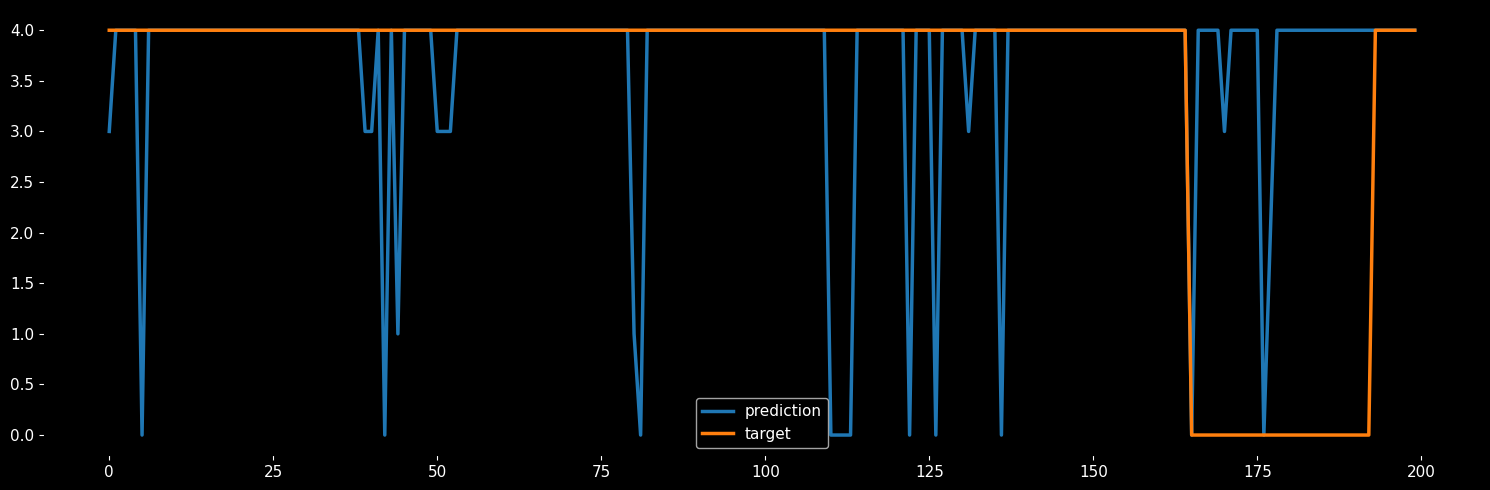

In [141]:
ids, embeddings = train_idx, train_embed

subj_id = real_data.iloc[0]['id']
rate = real_data.iloc[0]['rate']
channels = real_data.iloc[0]['channels']
window_len = int(0.1 * 200)

offset = real_data.iloc[0]['time'] // window_len
print(offset)
probs, labels, target = [], [], []
for i in range(offset, offset + 200):
    data = real_eeg[:, i * window_len : i * window_len + model.max_input_length]
    embedded = encoder(model.get_input({
        'eeg' : data, 'rate' : rate, 'channels' : channels, 'id' : subj_id
    })[None], training = False)
    pred = predict(embedded)[1][0].numpy()
    #pred = pred / np.sum(pred)
    probs.append(pred)
    target.append(all_targets[i * window_len + model.max_input_length])
    labels.append(np.argmax(pred))

target = np.array(target)
labels = np.array(labels)

plot({'prediction' : labels, 'target' : target}, figsize = (15, 5))

In [142]:
print(target)
print(labels)
_probs = np.around(probs, 3).reshape(-1, 10, len(probs[0])).max(axis = 1)
print(np.concatenate([_probs, target[::10, None]], axis = 1))
print(np.around(np.concatenate([probs, target[:, None]], axis = -1), decimals = 3))#.reshape((-1, 4, 4)).max(axis = 1))

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4]
[3 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 3 3 4 0 4 1 4 4 4 4 4 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 1 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0
 0 0 0 4 4 4 4 4 4 4 4 0 4 4 4 0 4 4 4 4 3 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 3 4 4 4 4 4 0 2 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[[ 1.98599994  1.551       1.00300002  2.33100009 31.37999916  4.        ]
 [ 0.          0.          0.          0.         49.01499939  4.        ]
 [ 0.          0.          0.       

In [118]:
print(model.labels)

['Finger 1 (thumb)', 'Finger 2 (index)', 'Finger 3 (middle)', 'Finger 4', 'Finger 5 (pinkie)', 'passive']


In [123]:
idx = -7
for idx in range(10):
    data = real_data.iloc[idx]['eeg'][:, :250]
    pred = model(model.get_input({
        'eeg' : data, 'rate' : rate, 'channels' : channels, 'id' : subj_id
    })[None], training = False)
    pred = np.around(tf.nn.softmax(pred)[0].numpy(), decimals = 3)
    #pred = predict(embedded, k = 15, weighted = False)[1][0].numpy()
    
    print(real_data.iloc[idx]['label'])
    print(pred)

passive
[0.002 0.001 0.    0.    0.    0.997]
passive
[0.828 0.074 0.005 0.001 0.072 0.02 ]
passive
[0. 0. 0. 0. 0. 1.]
passive
[0.425 0.103 0.031 0.024 0.324 0.094]
passive
[0. 0. 0. 0. 0. 1.]
passive
[0.031 0.035 0.166 0.51  0.243 0.015]
passive
[0. 0. 0. 0. 0. 1.]
passive
[0.107 0.181 0.325 0.262 0.122 0.003]
passive
[0. 0. 0. 0. 0. 1.]
passive
[0.446 0.415 0.109 0.017 0.008 0.006]


In [59]:
print(test_ids)

['Finger 1 (thumb)', 'Finger 3 (middle)', 'Finger 4', 'Finger 5 (pinkie)', 'passive']


In [57]:
real_data

,event_id,start,end,time,age,sex,meas_date,rate,channels,eeg,event_name,id,task,device,label,n_channels,dataset_name,session
0,0,1599,31612,30013,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
1,99,31612,31819,207,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-2.08e-06, -4.69e-06, -3.26e-06, -1.79e-06, ...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
2,0,31819,32621,802,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-3.905e-05, -3.896e-05, -4.179e-05, -4.127e-...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
3,99,32621,32826,205,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-1.151e-05, -2.03e-05, -1.986e-05, -2.337e-0...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
4,0,32826,33429,603,None,None,160405,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-3.189e-05, -2.617e-05, -2.836e-05, -3.388e-...",passive,Large scale BCI-A,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-A-160405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11525,0,716994,717418,424,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-6.84e-06, -1.786e-05, -1.437e-05, -6.11e-06...",passive,Large scale BCI-F,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-F-160209
11526,5,717418,717677,259,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[1.105e-05, 6.1e-06, 1.1e-07, 2.92e-06, 1.431...",Finger 5 (pinkie),Large scale BCI-F,5f,EEG 1200,Finger 5 (pinkie),22,Large scale BCI,Large scale BCI-F-160209
11527,0,717677,718142,465,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[4.27e-06, 2.16e-06, 4.83e-06, 1.208e-05, 1.2...",passive,Large scale BCI-F,5f,EEG 1200,passive,22,Large scale BCI,Large scale BCI-F-160209
11528,5,718142,718400,258,None,None,160209,200,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1,...","[[-8.84e-06, -1.61e-06, -5.13e-06, -4.65e-06, ...",Finger 5 (pinkie),Large scale BCI-F,5f,EEG 1200,Finger 5 (pinkie),22,Large scale BCI,Large scale BCI-F-160209


### Plots for MLSP 2024 embedding visualization

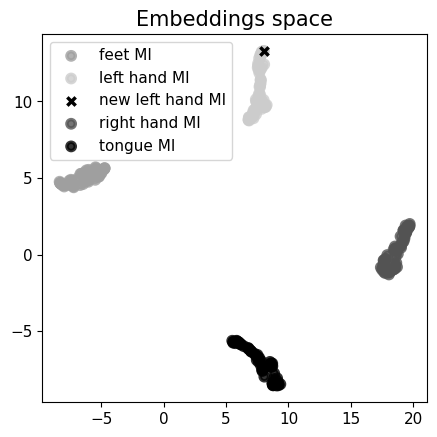

In [13]:
from utils import *

test_labels     = convert_to_str(tf.as_string(tf.reshape(test_samples['labels'], [-1])))
test_embeddings = tf.reshape(test_samples['embeddings'], [-1, test_samples['embeddings'].shape[-1]])

color_config = {
    'fontcolor' : 'black', 'facecolor' : 'white', 'with_grid' : False,
    'title' : 'Embeddings space', 'with_legend' : True
}
_colors = {
    'feet MI' : 1,
    'left hand MI' : 0,
    'right hand MI' : 2,
    'tongue MI' : 3
}

def _normalize_colors(colors, cmap = None):
    if (isinstance(colors, np.ndarray) and colors.dtype in (np.uint8, np.int32, np.int64)) or all(
        isinstance(c, int) for c in colors):
        colors = np.array(list(colors))
        mapper = plt.cm.ScalarMappable(cmap = cmap)
        colors = np.reshape(mapper.to_rgba(np.reshape(colors, [-1])), (len(colors), 4))
    
    return colors

train_labels = [label.replace('(IM)', 'MI') for label in convert_to_str(train_samples['labels'])]
colors = np.array([_colors[l] for l in train_labels])
colors = _normalize_colors(colors, cmap = 'Grays') * 0.8

idx = 3
plot_embedding(
    np.concatenate([train_samples['embeddings'], test_embeddings[idx : idx + 1]], axis = 0),
    train_labels + ['new {}'.format(test_labels[idx]).replace('(IM)', 'MI')],
    marker = ['o'] * len(train_samples['embeddings']) + ['x'],
    c = list(colors) + [[0., 0., 0., 1.]], filename = 'embedding_classification.png',
    ** color_config
)

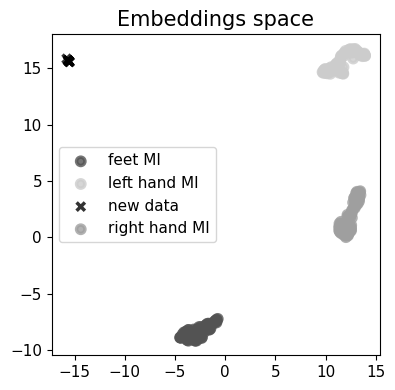

In [11]:
from utils import *

test_labels     = convert_to_str(tf.as_string(tf.reshape(test_samples['labels'], [-1])))
test_embeddings = tf.reshape(test_samples['embeddings'], [-1, test_samples['embeddings'].shape[-1]])

color_config = {
    'fontcolor' : 'black', 'facecolor' : 'white', 'with_grid' : False,
    'title' : 'Embeddings space', 'with_legend' : True
}
_colors = {
    'tongue MI' : 0,
    'left hand MI' : 1,
    'right hand MI' : 2,
    'feet MI' : 3,
    'new data' : 4
}

def _normalize_colors(colors, cmap = None):
    if (isinstance(colors, np.ndarray) and colors.dtype in (np.uint8, np.int32, np.int64)) or all(
        isinstance(c, int) for c in colors):
        colors = np.array(list(colors))
        mapper = plt.cm.ScalarMappable(cmap = cmap)
        colors = np.reshape(mapper.to_rgba(np.reshape(colors, [-1])), (len(colors), 4))
    
    return colors

count = 0
train_labels, embeddings = [], []
for label, emb in zip(convert_to_str(train_samples['labels']), train_samples['embeddings']):
    if label == 'tongue (IM)':
        if count >=10: continue
        label = 'new data'
        count += 1
    embeddings.append(emb)
    train_labels.append(label.replace('(IM)', 'MI'))

colors = np.array([_colors[l] for l in train_labels]) + 1
colors = _normalize_colors(colors, cmap = 'Grays') * 0.8

idx = 3
plot_embedding(
    np.array(embeddings),
    train_labels,
    marker = ['o' if label != 'new data' else 'x' for label in train_labels],
    c = list(colors), filename = 'embedding_label_free.png',
    ** color_config
)

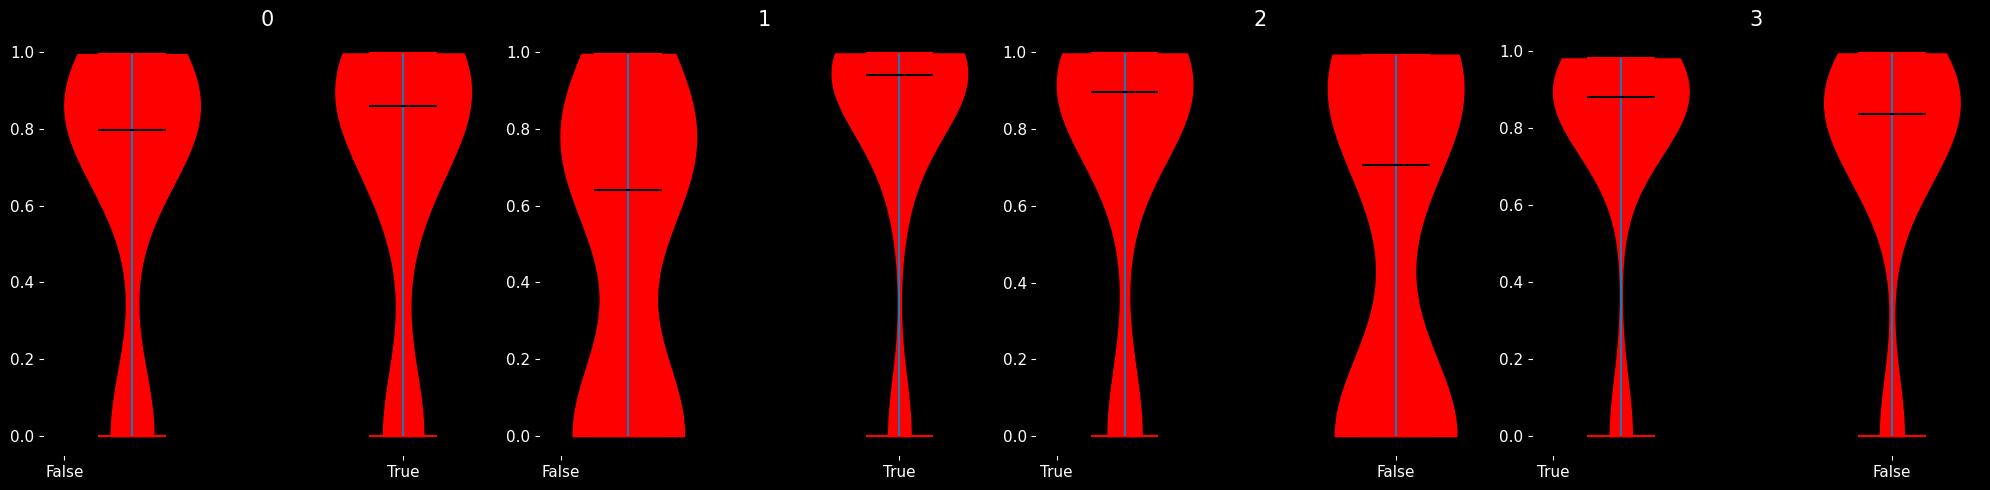

In [52]:
scores_per_label = {}
for s, t, p in zip(scores, np.array(test_idx), np.array(pred)):
    scores_per_label.setdefault(str(t), {}).setdefault(str(t == p), []).append(s[p] / np.sum(s))

#scores_per_label = {
#    k : {ki : np.mean(vi) for ki, vi in v.items()} for k, v in scores_per_label.items()
#}
plot_multiple(
    ** {k : {'x' : v} for k, v in scores_per_label.items()},
    plot_type = 'violinplot', use_subplots = True, ncols = 4
)

Accuracy : 72.57 %
Accuracy : 72.57 %


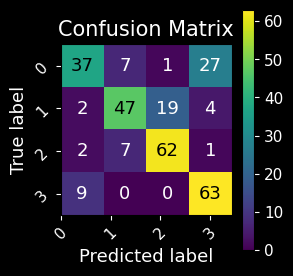

In [43]:
k = 25

_, scores = knn(
    test_embed, train_embed, distance_metric = model.distance_metric, k = k, ids = train_idx, weighted = True, return_scores = True
)

pred = np.argmax(scores, axis = -1)

pred2 = knn(
    test_embed, test_embed, distance_metric = model.distance_metric, k = k, ids = pred, weighted = True
)

order = np.argsort(np.max(scores, axis = -1))[::-1]
indexes = order[:5]

true = test_idx.numpy()

print('Accuracy : {:.2f} %'.format(np.mean(pred == true) * 100))
print('Accuracy : {:.2f} %'.format(np.mean(pred2 == true) * 100))
plot_confusion_matrix(true = true, pred = pred)

#plot(cross_acc, plot_type = 'bar')

In [33]:
labels, scores = model.infer_multi_channels(
    tf.stack(model.get_input(test), axis = 0),
    channels = list(test['channels'].values),
    samples = samples,
    weighted = False,
    k = 15
)
print(scores)

[[[ 0.  7.  0.  8.]
  [ 0. 14.  0.  1.]
  [ 0. 14.  0.  1.]
  ...
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]]

 [[15.  0.  0.  0.]
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  ...
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  [ 0. 14.  0.  1.]]

 [[ 0. 14.  0.  1.]
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]
  ...
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]]

 ...

 [[ 0.  1.  0. 14.]
  [ 0.  1. 13.  1.]
  [ 0.  2.  2. 11.]
  ...
  [ 0.  0.  2. 13.]
  [ 0.  0.  2. 13.]
  [ 0.  0.  0. 15.]]

 [[ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  ...
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  [ 0.  0.  8.  7.]]

 [[14.  1.  0.  0.]
  [15.  0.  0.  0.]
  [15.  0.  0.  0.]
  ...
  [ 1.  8.  5.  1.]
  [ 0.  9.  6.  0.]
  [ 0.  1. 14.  0.]]]


In [23]:
test_idx = test['label'].apply(labels.index).values
print(test_idx)

[3 0 0 3 0 3 0 1 0 2 3 1 0 3 2 2 2 2 2 3 1 0 3 3 1 2 3 1 1 1 3 0 3 0 0 3 0
 1 0 1 1 2 1 1 2 2 2 2 2 1 0 3 3 0 1 2 0 1 3 3 3 2 0 0 3 3 1 3 0 2 2 1 3 2
 2 0 2 2 0 3 0 1 1 1 2 1 3 2 0 1 0 1 2 0 1 3 3 3 2 0 3 1 3 1 0 2 3 1 1 3 1
 0 2 2 2 1 3 2 0 2 0 3 1 0 3 1 1 3 1 2 2 0 3 0 2 0 2 1 0 0 0 1 2 3 0 2 3 1
 1 2 3 3 1 0 2 2 2 0 3 1 0 2 3 2 1 0 2 2 3 0 0 1 2 0 3 3 2 0 3 1 0 0 1 3 2
 1 1 1 1 3 0 3 0 3 3 1 1 0 1 2 3 2 3 3 0 2 1 0 2 1 2 1 2 0 0 2 3 0 0 0 1 2
 3 2 3 1 3 2 3 1 3 0 1 1 2 3 0 2 0 1 1 3 2 0 2 3 3 1 1 0 2 0 0 3 0 2 2 0 0
 0 0 2 2 1 2 3 0 1 0 3 2 3 2 3 3 3 3 1 1 2 0 1 1 1 2 1 3 1]


Accuracy (k = 50) : 35.76 %


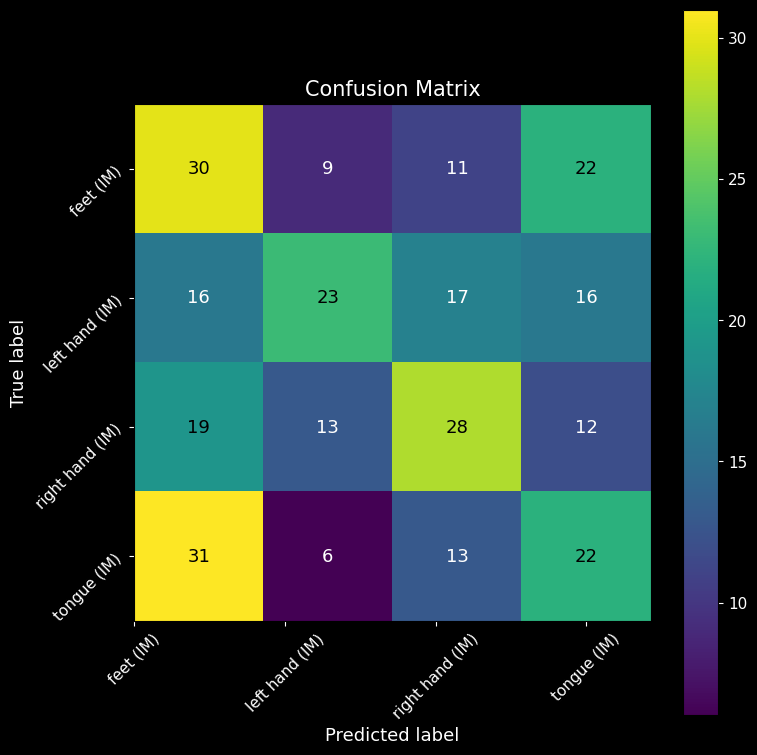

In [38]:
channels = [0, 12]
pred = np.argmax(np.sum(scores[:, channels], axis = 1), axis = -1)

print('Accuracy (k = {}) : {:.2f} %'.format(k, np.mean(pred == test_idx) * 100))
plot_confusion_matrix(true = test_idx, pred = pred, labels = convert_to_str(test_ids), factor_size = 2)

## Test evaluation

In [2]:
from datasets import print_datasets, get_dataset

print_datasets()

ds = get_dataset('mnistep')
ds

Task BCI :	('bciiv2a', 'brainmnist', 'mnistin', 'mnistmu', 'mnistmw', 'mnistep', 'eegmmidb', 'largescalebci')
Task Sleep analysis :	('cinc',)
Task EEG emotion recognition :	('seed',)
Available keras datasets : ['cifar10', 'cifar100', 'fashion_mnist', 'imdb', 'mnist', 'reuters']
Loading dataset mnistep...


,event_id,event_name,device,rate,channels,eeg,start,end,time,label,id,n_channels,dataset_name
0,67635,6,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004395385, 0.004382564, 0.004377436, 0.004...",0,260,260,6,Brain MNIST,14,Brain MNIST
1,67636,7,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004385641, 0.0043815384, 0.0043866667, 0.0...",260,520,260,7,Brain MNIST,14,Brain MNIST
2,67637,9,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004380513, 0.004389744, 0.0043958975, 0.00...",520,776,256,9,Brain MNIST,14,Brain MNIST
3,67638,9,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.0043958975, 0.004390769, 0.0044035898, 0.0...",776,1040,264,9,Brain MNIST,14,Brain MNIST
4,67639,0,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004395385, 0.004385128, 0.004382051, 0.004...",1040,1300,260,0,Brain MNIST,14,Brain MNIST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65029,132664,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004401026, 0.004413846, 0.0044107693, 0.00...",16875817,16876073,256,-1,Brain MNIST,14,Brain MNIST
65030,132665,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004419487, 0.0044184616, 0.0044230768, 0.0...",16876073,16876329,256,-1,Brain MNIST,14,Brain MNIST
65031,132666,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004414872, 0.004402564, 0.0043923077, 0.00...",16876329,16876585,256,-1,Brain MNIST,14,Brain MNIST
65032,132667,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.0044897436, 0.004491282, 0.004489231, 0.00...",16876585,16876841,256,-1,Brain MNIST,14,Brain MNIST


In [2]:
import os
import importlib
import numpy as np
import pandas as pd

from tqdm import tqdm

from experiments import scenarios, data_utils, get_experimental_data, build_model, validate_scenario_data
from experiments.scenarios import _setup_gpu_config, _get_scenario_config, _get_metrics

importlib.reload(data_utils)

model_name = 'atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2'

config = _get_scenario_config(model_name, gpu = 0)

_setup_gpu_config(config, gpu = 0)

train, valid, test, config = data_utils.get_experimental_data(
    config, random_state = config['run']
)

validate_scenario_data(config, train = train, valid = valid, test = test)

model, config = build_model(model_name, config)

2024-02-15 09:31:52.362809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 09:31:52.393612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 09:31:52.393640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 09:31:52.394374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 09:31:52.399188: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_follow_type_hints is deprecated
Loading dataset bci-iv_2a...


2024-02-15 09:32:15.946880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14948 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


`val_split is None`, which makes the validation and test sets equal ! Make sure that it is expected

Dataset information

General :
  - sampling rate  : 250
  - # EEG channels : 22
  - Labels (n = 36) : ['BCI-IV 2a-7-left hand (IM)', 'BCI-IV 2a-4-right hand (IM)', 'BCI-IV 2a-2-feet (IM)', 'BCI-IV 2a-4-left hand (IM)', 'BCI-IV 2a-7-tongue (IM)', ...]

# Samples :
  - Train size    : 4147
  - Valid size    : 1037
  - Test size     : 1037
  - valid == test : True

Subjects :
  - # subject(s) in train : 9
  - # subject(s) in valid : 9
  - # subject(s) in test  : 9
  - # subject(s) in train and valid : 9
  - # subject(s) in train and test  : 9

Sessions :
  - # session(s) in train : 18
  - # session(s) in valid : 18
  - # session(s) in test  : 18
  - # session(s) in train and valid : 18
  - # session(s) in train and test  : 18

Model restoration...
Model model has not been restored due to an exception : Requested the deserialization of a Lambda layer with a Python `lambda` inside it. This c

In [3]:
importlib.reload(scenarios)

config['metrics'] = scenarios._get_metrics(model_name, config)

config

{'scenario': 2,
 'model_name': 'atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2',
 'model_type': 'classifier',
 'pretrained': None,
 'skip_new': False,
 'scenario_config': {'train_on_multi_subjects': True},
 'dataset_config': {'task': 'classification',
  'test_task': 'classification',
  'dataset': 'bci-iv_2a',
  'subjects': ['1', '2', '3', '4', '5', '6', '7', '8', '9'],
  'loso': 0,
  'val_split': None,
  'test_split': 0.2,
  'per_user_label': True,
  'time_window': 4.5,
  'offset': 1.5,
  'test_sessions': 0},
 'model_config': {'nom': 'atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2',
  'rate': 250,
  'architecture_name': 'atcnet',
  'normalization_config': {'normalize': <EEGNormalization.GLOBAL_NORMAL: 5>,
   'per_channel': True},
  'keep_spatial_information': 'auto',
  'max_input_length': 4.5,
  'use_fixed_length_input': True,
  'channels': ['EEG-1',
   'EEG-2',
   'EEG-3',
   'EEG-4',
   'EEG-5',
   'EEG-6',
   'EEG-7',
   'EEG-8',
   'EEG-9',
   'EEG-10',
   'EEG-11

In [5]:
filepath = model.save_dir + '/best_weights.keras'
model.load_weights(filepath)
pred = model.predict(test, mask_by_id = True)

print(np.mean([v for k, v in config['metrics'].items() if 'masked' in k and v is not None]))
print(np.mean(np.array([p['pred'] for p in pred]) == test['label'].values))

0.8273294568061829
0.8273866923818708


In [9]:
import os
import json
import logging
import numpy as np
import pandas as pd

from utils import to_json

logger = logging.getLogger(__name__)

importlib.reload(scenarios)

metrics = scenarios.evaluate_model(
    model, config, data = test, filepath = filepath, save = False
)
metrics

Model `atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2` metrics : {
    "test_accuracy": 0.8273866923818708,
    "test_subj-BCI-IV 2a-1_accuracy": 0.8620689655172413,
    "test_subj-BCI-IV 2a-2_accuracy": 0.6810344827586207,
    "test_subj-BCI-IV 2a-3_accuracy": 0.9217391304347826,
    "test_subj-BCI-IV 2a-4_accuracy": 0.7739130434782608,
    "test_subj-BCI-IV 2a-5_accuracy": 0.8608695652173913,
    "test_subj-BCI-IV 2a-6_accuracy": 0.7368421052631579,
    "test_subj-BCI-IV 2a-7_accuracy": 0.896551724137931,
    "test_subj-BCI-IV 2a-8_accuracy": 0.8508771929824561,
    "test_subj-BCI-IV 2a-9_accuracy": 0.8620689655172413
}
Model `atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2` metrics : {
    "test_masked_accuracy": 0.8273866923818708,
    "test_masked_subj-BCI-IV 2a-1_accuracy": 0.8620689655172413,
    "test_masked_subj-BCI-IV 2a-2_accuracy": 0.6810344827586207,
    "test_masked_subj-BCI-IV 2a-3_accuracy": 0.9217391304347826,
    "test_masked_subj-BCI-IV 2a-4_accuracy

{'test_accuracy': 0.8273866923818708,
 'test_subj-BCI-IV 2a-1_accuracy': 0.8620689655172413,
 'test_subj-BCI-IV 2a-2_accuracy': 0.6810344827586207,
 'test_subj-BCI-IV 2a-3_accuracy': 0.9217391304347826,
 'test_subj-BCI-IV 2a-4_accuracy': 0.7739130434782608,
 'test_subj-BCI-IV 2a-5_accuracy': 0.8608695652173913,
 'test_subj-BCI-IV 2a-6_accuracy': 0.7368421052631579,
 'test_subj-BCI-IV 2a-7_accuracy': 0.896551724137931,
 'test_subj-BCI-IV 2a-8_accuracy': 0.8508771929824561,
 'test_subj-BCI-IV 2a-9_accuracy': 0.8620689655172413,
 'test_masked_accuracy': 0.8273866923818708,
 'test_masked_subj-BCI-IV 2a-1_accuracy': 0.8620689655172413,
 'test_masked_subj-BCI-IV 2a-2_accuracy': 0.6810344827586207,
 'test_masked_subj-BCI-IV 2a-3_accuracy': 0.9217391304347826,
 'test_masked_subj-BCI-IV 2a-4_accuracy': 0.7739130434782608,
 'test_masked_subj-BCI-IV 2a-5_accuracy': 0.8608695652173913,
 'test_masked_subj-BCI-IV 2a-6_accuracy': 0.7368421052631579,
 'test_masked_subj-BCI-IV 2a-7_accuracy': 0.8965517

## Test data loading

In [25]:
import json
import importlib

from utils import set_display_options
from experiments import data_utils, model_utils, scenarios

set_display_options()

for module in (model_utils, data_utils, scenarios): importlib.reload(module)

model_name = 'atcnet_task-cli_subj-1_run-10'

config = scenarios._get_scenario_config(model_name)
train, val, test, config = data_utils.get_experimental_data(config)
print(json.dumps(config, indent = 4))

print(train.head())
print(test.head())

Loading dataset bciiv2a...

Dataset information

General :
  - sampling rate  : 250
  - # EEG channels : 1

Labels :
  - Label in train (n = 88) : ['right hand (IM)-EEG-3', 'feet (IM)-EEG-20', 'left hand (IM)-EEG-15', 'feet (IM)-EEG-17', 'left hand (IM)-EEG-17', ...]
  - Label in valid (n = 88) : ['feet (IM)-EEG-20', 'right hand (IM)-EEG-3', 'left hand (IM)-EEG-15', 'feet (IM)-EEG-17', 'left hand (IM)-EEG-17', ...]
  - Label in test  (n = 4) : {'feet (IM)', 'tongue (IM)', 'left hand (IM)', 'right hand (IM)'}
  - # label(s) in train and valid : 88
  - # label(s) in train and test  : 0

# Samples :
  - Train size    : 5060
  - Valid size    : 1276
  - Test size     : 288
  - valid == test : False

Subjects :
  - # subject(s) in train : 1
  - # subject(s) in valid : 1
  - # subject(s) in test  : 1
  - # subject(s) in train and valid : 1
  - # subject(s) in train and test  : 1

Sessions :
  - # session(s) in train : 1
  - # session(s) in valid : 1
  - # session(s) in test  : 1
  - # sessio

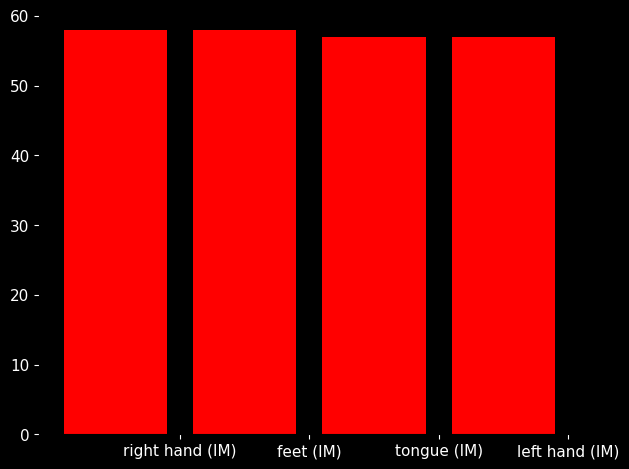

label
right hand (IM)    58
feet (IM)          58
tongue (IM)        57
left hand (IM)     57
Name: count, dtype: int64

In [24]:
from utils import plot

plot(train['label'].value_counts().to_dict(), plot_type = 'bar')
train['label'].value_counts()

## Test GE2E generator

In [5]:
import json
import importlib
import tensorflow as tf

from datasets import get_dataset, prepare_dataset
from custom_train_objects.generators import eeg_generator

try:
    tf.config.set_visible_devices([], 'GPU')
except:
    pass

In [9]:
data = get_dataset('bci-iv_2a', modes = 'train', subjects = 1)

print('Dataset columns : {}'.format(list(data.columns)))
print('# data : {}'.format(len(data)))

Loading dataset bciiv2a...
Dataset columns : ['event_id', 'start', 'end', 'time', 'age', 'sex', 'meas_date', 'event_name', 'artifact', 'rate', 'channels', 'eeg', 'id', 'session', 'label', 'n_channels', 'dataset_name']
# data : 288


In [10]:
importlib.reload(eeg_generator)

generator = eeg_generator.EEGGrouperGenerator(
    data, n_utterance = 4, n_round = 10
)
print(generator)

EEGGrouper Generator :
- Length : 160
- Unique ids   : 4
- Total files  : 160
- Unique files : 120 (75.00 %)
- Cache size   : 0 (loaded : 0.00 %)


In [13]:
dataset = prepare_dataset(generator, batch_size = 16, padded_batch = True)
for batch in dataset.take(5):
    print(batch['label'])


tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'left hand (IM)' b'left hand (IM)' b'left hand (IM)' b'right hand (IM)'
 b'right hand (IM)' b'right hand (IM)' b'right hand (IM)' b'tongue (IM)'
 b'tongue (IM)' b'tongue (IM)' b'tongue (IM)'], shape=(16,), dtype=string)
tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'left hand (IM)' b'left hand (IM)' b'left hand (IM)' b'right hand (IM)'
 b'right hand (IM)' b'right hand (IM)' b'right hand (IM)' b'tongue (IM)'
 b'tongue (IM)' b'tongue (IM)' b'tongue (IM)'], shape=(16,), dtype=string)
tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'left hand (IM)' b'left hand (IM)' b'left hand (IM)' b'right hand (IM)'
 b'right hand (IM)' b'right hand (IM)' b'right hand (IM)' b'tongue (IM)'
 b'tongue (IM)' b'tongue (IM)' b'tongue (IM)'], shape=(16,), dtype=string)
tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'lef

2024-02-19 10:18:27.713657: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Test experiments

In [12]:
import json
import importlib

from utils import to_json

from experiments import model_utils, scenarios_utils

importlib.reload(model_utils)
importlib.reload(scenarios_utils)

test = False

_suffixes      = ['', '_lss', '_norm-no', '_norm-no_lss', '_norm-no_win', '_norm-no_lss_win']
_orig_suffixes = ['', '_lss'] if not test else ['']

_scenarios = ['_scenario-1', '_scenario-2', '_scenario-3', '_scenario-4'] #if not test else ['_scenario-3']
original_experimental_models = (
    'atcnet_orig_subj-{subject}_run-{run}',
    'atcnet_subj-{subject}_run-{run}',
    'eegnex_subj-{subject}_run-{run}',
    'eegtcnet_subj-{subject}_run-{run}',
    'deepconvnet_subj-{subject}_run-{run}'
)

experimental_models = []
for exp in original_experimental_models[:2]:
    experimental_models.extend([
        exp + suffix for suffix in (_suffixes if 'orig' not in exp else _orig_suffixes)
    ])

experiments = []
for exp in experimental_models:
    experiments.extend([
        exp + scenario for scenario in _scenarios
    ])


for name in experiments:
    config = model_utils.get_model_config(name)
    print('{} : {}'.format(name, json.dumps(to_json(config), indent = 4)))
    config = scenarios_utils.add_scenario_config(config['scenario'], config)
    print('Updated config : {}\n\n'.format(json.dumps(to_json(config), indent = 4)))
    try:
        scenarios_utils.validate_scenario_config(config['scenario'], config)
    except scenarios_utils.InvalidScenarioException as e:
        print('This scenario is invalid : {}\n\n'.format(e))


Unknown json data (<class 'function'>) : <function get_model_config.<locals>.<lambda> at 0x7f4b50cc7920>
atcnet_orig_subj-{subject}_run-{run}_scenario-1 : {
    "scenario": 1,
    "model_type": "classifier",
    "pretrained": null,
    "scenario_config": {},
    "dataset_config": {
        "dataset": "bci-iv_2a",
        "subjects": null,
        "loso": 0,
        "val_split": null,
        "per_user_label": false,
        "time_window": 4.5,
        "offset": 1.5
    },
    "model_config": {
        "architecture_name": "atcnet",
        "normalization_config": {
            "normalize": 5,
            "per_channel": true
        },
        "keep_spatial_information": "auto",
        "max_input_length": 4.5,
        "use_fixed_length_input": true
    },
    "compile_config": {
        "optimizer": "adam",
        "optimizer_config": {
            "lr": 0.001
        }
    },
    "train_config": {
        "epochs": 1000,
        "batch_size": 64,
        "monitor": "test_accuracy",
  

## Test label mapping

In [ ]:
import importlib
import tensorflow as tf

from utils.eeg_utils import label_utils

try:
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[:1], 'GPU')
except:
    pass

importlib.reload(label_utils)

labels  = [None, 'bci', 'sleep']
mapping = [None, ('left', 'right'), ('stage_1', 'stage_2')]

print(label_utils.build_lookup_table(labels, mapping))